<a href="https://colab.research.google.com/github/fire-classifying/fireclass/blob/master/fire_classify_2classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ejecuta esta celda para activar tu cuenta de Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install fastai==0.7.0


     |████████████████████████████████| 122kB 3.4MB/s 
     |████████████████████████████████| 1.5MB 10.8MB/s 
     |████████████████████████████████| 496.4MB 40kB/s 
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: fastai 1.0.54
    Uninstalling fastai-1.0.54:
      Successfully uninstalled fastai-1.0.54


In [0]:
# En primer lugar importamos las librerías

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from fastai.imports import *
from fastai.structured import *
from scipy.stats import norm
from scipy import stats

import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline 

RANDOM_SEED = 33

plt.style.use('bmh')

In [6]:
# Iniciamos el proceso de análisis, estudiando los datos disponibles

df = pd.read_csv('/content/drive/My Drive/Incendios_dataset.csv', delimiter = ',') 

df.head(10)

,fecha,Mod_comb,NDVI,sup_quemad,sup_arb,sup_pastiz,sup_matorr,w_arb,w_pastiz,w_matorr,rk_Cuenc_F,rk_hist_Cu,rk_hist_us,rk_orograf,rk_peligro,rk_pte,vuln_equip,vuln_forve,vuln_infra,vuln_max,vuln_pathi,LST,rk_combUSIF,rk_combCuencExtr,rk_combCuencSup,Velocidad_Viento,Dirección_Viento,Humedad_Relativa,Temperatura_Máxima,Temperatura_Media,ETo_acumulada,Precipitación_acumulada
0,13/08/2008,7.0,3747.28,37.900002,37.900002,0.000000,0.000000,1.000000,0.000000,0.000000,5,5,2,2,1,1,1,4,2,4,1,39.19,4,4,3,1.0,310.0,43.0,34.0,23.8,1043.41,487.4
1,30/06/2008,4.0,3981.50,17.077999,16.073999,1.004000,0.000000,0.941211,0.058789,0.000000,5,5,5,2,3,4,1,4,5,5,1,33.99,5,5,4,1.6,268.8,48.6,38.4,28.9,968.59,658.2
2,15/07/2009,1.0,3811.66,18.040001,0.180000,14.740000,3.120000,0.009978,0.817073,0.172949,3,4,3,3,1,2,1,4,3,4,1,42.45,5,4,4,1.6,240.0,38.0,37.0,26.1,1087.09,411.0
3,25/07/2009,10.0,3536.00,10.120000,0.000000,10.120000,0.000000,0.000000,1.000000,0.000000,5,5,3,2,2,1,1,3,5,5,1,46.99,5,5,4,1.2,292.0,42.5,39.2,29.1,1129.46,508.2
4,28/05/2009,NaN,2132.06,56.220001,15.590000,0.000000,40.630001,0.277303,0.000000,0.722697,5,5,3,2,1,1,1,3,5,5,1,33.75,5,5,5,1.3,290.0,37.4,33.3,24.5,741.75,495.2
5,24/06/2009,NaN,NaN,11.000000,0.000000,11.000000,0.000000,0.000000,1.000000,0.000000,4,4,5,2,1,1,1,3,4,4,1,43.05,5,5,5,2.0,298.4,80.1,29.7,22.7,884.09,369.2
6,03/07/2009,3.0,2384.00,27.180000,6.850000,9.479999,10.850000,0.252024,0.348786,0.399191,4,3,1,2,2,1,1,3,5,5,1,47.89,1,1,1,2.0,290.0,77.0,38.7,29.2,963.57,439.8
7,14/08/2009,NaN,NaN,11.979999,8.720000,1.230000,2.030000,0.727880,0.102671,0.169449,3,4,2,2,1,1,1,4,5,5,1,40.25,4,5,5,2.2,323.1,28.0,37.3,28.4,1344.11,548.2
8,28/08/2010,6.0,4338.80,29.169001,21.518000,0.631000,7.020000,0.737701,0.021633,0.240666,5,5,5,2,3,4,1,4,3,4,1,41.77,5,5,5,1.5,230.0,68.1,38.4,30.1,1289.75,1256.4
9,25/07/2010,1.0,4090.40,27.150000,2.200000,0.000000,24.950001,0.081031,0.000000,0.918969,5,4,2,2,2,1,1,4,2,4,1,36.49,4,3,2,1.6,254.0,78.0,35.6,27.5,1179.75,901.0


In [7]:
df.columns

Index(['fecha', 'Mod_comb', 'NDVI', 'sup_quemad', 'sup_arb', 'sup_pastiz',
       'sup_matorr', 'w_arb', 'w_pastiz', 'w_matorr', 'rk_Cuenc_F',
       'rk_hist_Cu', 'rk_hist_us', 'rk_orograf', 'rk_peligro', 'rk_pte',
       'vuln_equip', 'vuln_forve', 'vuln_infra', 'vuln_max', 'vuln_pathi',
       'LST', 'rk_combUSIF', 'rk_combCuencExtr', 'rk_combCuencSup',
       'Velocidad_Viento', 'Dirección_Viento', 'Humedad_Relativa',
       'Temperatura_Máxima', 'Temperatura_Media', 'ETo_acumulada',
       'Precipitación_acumulada'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 32 columns):
fecha                      110 non-null object
Mod_comb                   98 non-null float64
NDVI                       102 non-null float64
sup_quemad                 110 non-null float64
sup_arb                    66 non-null float64
sup_pastiz                 66 non-null float64
sup_matorr                 66 non-null float64
w_arb                      66 non-null float64
w_pastiz                   66 non-null float64
w_matorr                   66 non-null float64
rk_Cuenc_F                 110 non-null int64
rk_hist_Cu                 110 non-null int64
rk_hist_us                 110 non-null int64
rk_orograf                 110 non-null int64
rk_peligro                 110 non-null int64
rk_pte                     110 non-null int64
vuln_equip                 110 non-null int64
vuln_forve                 110 non-null int64
vuln_infra                 110 non-null int64
vuln_max 

# Data Mining

In [0]:
# Añadimos columnas fechaYear, FechaMonth, etc al dataset
add_datepart(df, 'fecha')

In [0]:
# imputacion de valores NaN mediante el valor medio de cada columna

def impute_nan_by_mean(dataframe):
 
 df = dataframe.copy()
 list_columns = df.columns[df.columns != 'category'] #-> Esto no está funcionando bien. Aquí sí, porque aún no hemos creado categorías
 
 for var in list_columns:
   
   #if type(dataframe[var]) != "category":
     mean_var = df[var].mean()
     df[var] = df[var].replace(np.nan, mean_var)
 
 return df

In [0]:
df = impute_nan_by_mean(df)

In [0]:
# El campo 'cat_incendio' lo categorizamos en función de la superficie quemada
# 1 -> pequeño (sup < 200Ha)
# 2 -> grande (sup > 200 Ha)
binInterval = [0,200,100000] 
binLabels = [1,2] 
df['cat_incendio'] = pd.cut(df['sup_quemad'], bins = binInterval, labels=binLabels)

In [13]:
import collections
print(collections.Counter(df.cat_incendio))

Counter({1: 82, 2: 28})


In [0]:
# El campo 'cat_dir_viento' lo categorizamos en función de la dirección del viento
# 0 = dir < 45º
# 1 = 45º < dir < 90º
# 2 = 90º < dir < 135º
# 3 = 135º < dir < 180º
# 4 = 180º < dir < 225º
# 5 = 225º < dir < 270º
# 6 = 270º < dir < 315º
# 7 = 315º < dir < 360º

binInterval = [-1,45,90,135,180,225,270,315,360] 
binLabels = [0,1,2,3,4,5,6,7] 
df['cat_dir_viento'] = pd.cut(df['Dirección_Viento'], bins = binInterval, labels=binLabels)

In [0]:
# Añadimos una columna nueva y eliminamos las dos originales
df['ned_hidricas'] = df.ETo_acumulada - df.Precipitación_acumulada
df.drop('ETo_acumulada', axis = 1, inplace = True)
df.drop('Precipitación_acumulada', axis = 1, inplace = True)

In [0]:
# Hacemos lo mismo con la vulnerabilidad, sustituyéndola por una media de las existentes
df['vulnerabilidad'] = df[['vuln_equip','vuln_forve','vuln_infra','vuln_max','vuln_pathi']].mean(axis = 1)
df.drop('vuln_equip', axis = 1, inplace = True)
df.drop('vuln_forve', axis = 1, inplace = True)
df.drop('vuln_infra', axis = 1, inplace = True)
df.drop('vuln_max', axis = 1, inplace = True)
df.drop('vuln_pathi', axis = 1, inplace = True)

In [0]:
#Eliminamos los riesgos de cuenca y modelos combustible por una variable única llamada riesgos. Los demás riesgos entendemos que deben existir

df['riesgos_generales_cuenca'] = df[['rk_Cuenc_F','rk_hist_Cu','rk_hist_us','rk_combUSIF','rk_combCuencExtr','rk_combCuencSup']].mean(axis = 1)
df.drop('rk_Cuenc_F', axis = 1, inplace = True)
df.drop('rk_hist_Cu', axis = 1, inplace = True)
df.drop('rk_hist_us', axis = 1, inplace = True)
df.drop('rk_combUSIF', axis = 1, inplace = True)
df.drop('rk_combCuencExtr', axis = 1, inplace = True)
df.drop('rk_combCuencSup', axis = 1, inplace = True)

In [0]:
#Eliminamos los riesgos de pendientes y orografía por una sola variable
df['riesgos_pendientes'] = df[['rk_orograf','rk_pte']].mean(axis = 1)
df.drop('rk_orograf', axis = 1, inplace = True)
df.drop('rk_pte', axis = 1, inplace = True)

In [0]:
#Eliminamos las variables que están correlacionadas con la variable respuesta
df.drop('sup_arb', axis = 1, inplace = True)
df.drop('sup_pastiz', axis = 1, inplace = True)
df.drop('sup_matorr', axis = 1, inplace = True)
df.drop('w_arb', axis = 1, inplace = True)
df.drop('w_pastiz', axis = 1, inplace = True)
df.drop('w_matorr', axis = 1, inplace = True)

In [0]:
# Normalizamos el NDVI para que tome valores entre -1 y 1
df['ndvi_norm'] = ((df.NDVI -df.NDVI.mean())/df.NDVI.std())+(3/6)

In [0]:
#Eliminación de la temperatura máxima
df.drop('Temperatura_Máxima', axis = 1, inplace = True)

In [0]:
# Redondear valor de Mod_comb

df['Mod_comb']=round(df['Mod_comb'])

In [23]:
df.columns

Index(['Mod_comb', 'NDVI', 'sup_quemad', 'rk_peligro', 'LST',
       'Velocidad_Viento', 'Dirección_Viento', 'Humedad_Relativa',
       'Temperatura_Media', 'fechaYear', 'fechaMonth', 'fechaWeek', 'fechaDay',
       'fechaDayofweek', 'fechaDayofyear', 'fechaIs_month_end',
       'fechaIs_month_start', 'fechaIs_quarter_end', 'fechaIs_quarter_start',
       'fechaIs_year_end', 'fechaIs_year_start', 'fechaElapsed',
       'cat_incendio', 'cat_dir_viento', 'ned_hidricas', 'vulnerabilidad',
       'riesgos_generales_cuenca', 'riesgos_pendientes', 'ndvi_norm'],
      dtype='object')

In [24]:
df.head()

,Mod_comb,NDVI,sup_quemad,rk_peligro,LST,Velocidad_Viento,Dirección_Viento,Humedad_Relativa,Temperatura_Media,fechaYear,fechaMonth,fechaWeek,fechaDay,fechaDayofweek,fechaDayofyear,fechaIs_month_end,fechaIs_month_start,fechaIs_quarter_end,fechaIs_quarter_start,fechaIs_year_end,fechaIs_year_start,fechaElapsed,cat_incendio,cat_dir_viento,ned_hidricas,vulnerabilidad,riesgos_generales_cuenca,riesgos_pendientes,ndvi_norm
0,7.0,3747.28,37.900002,1,39.19,1.0,310.0,43.0,23.8,2008,8,33,13,2,226,False,False,False,False,False,False,1218585600,1,6,556.01,2.4,3.833333,1.5,0.469908
1,4.0,3981.50,17.077999,3,33.99,1.6,268.8,48.6,28.9,2008,6,27,30,0,182,True,False,True,False,False,False,1214784000,1,5,310.39,3.2,4.833333,3.0,0.548545
2,1.0,3811.66,18.040001,1,42.45,1.6,240.0,38.0,26.1,2009,7,29,15,2,196,False,False,False,False,False,False,1247616000,1,5,676.09,2.6,3.833333,2.5,0.491523
3,10.0,3536.00,10.120000,2,46.99,1.2,292.0,42.5,29.1,2009,7,30,25,5,206,False,False,False,False,False,False,1248480000,1,6,621.26,3.0,4.500000,1.5,0.398973
4,6.0,2132.06,56.220001,1,33.75,1.3,290.0,37.4,24.5,2009,5,22,28,3,148,False,False,False,False,False,False,1243468800,1,6,246.55,3.0,4.666667,1.5,-0.072385


In [0]:
# Eliminar columnas innecesarias

df.drop(['sup_quemad','fechaYear', 'fechaIs_month_end',
       'fechaIs_month_start', 'fechaIs_quarter_end', 'fechaIs_quarter_start',
       'fechaIs_year_end', 'fechaIs_year_start', 'fechaElapsed', 'NDVI', 'Dirección_Viento'], axis = 1, inplace = True)


In [0]:
# Eliminar nas en variable a predecir
df1= df.dropna(axis=0)


In [0]:
df1.to_csv("/content/drive/My Drive/Incendios_dataset_model.csv")

#Train/Test y Estandarización

In [28]:
df1.columns

Index(['Mod_comb', 'rk_peligro', 'LST', 'Velocidad_Viento', 'Humedad_Relativa',
       'Temperatura_Media', 'fechaMonth', 'fechaWeek', 'fechaDay',
       'fechaDayofweek', 'fechaDayofyear', 'cat_incendio', 'cat_dir_viento',
       'ned_hidricas', 'vulnerabilidad', 'riesgos_generales_cuenca',
       'riesgos_pendientes', 'ndvi_norm'],
      dtype='object')

In [0]:
#Se separan las entradas de las salidas
    outputs = df1.iloc[:,11]
    data_=df1.drop(['cat_incendio'],axis=1)
    inputs = data_.iloc[:,:]
    Input_Data = inputs.values[:,:]
    Output_Data = list(outputs.values[:])

In [0]:
# Separacion muestra: entrenamiento y test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Input_Data,Output_Data,test_size=0.3, stratify=df1.cat_incendio)

In [0]:
# Normalizar valores antes de introducir en el modelo
Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

# Primera aproximación modelos (sin optimizar)

In [32]:
from sklearn.metrics import accuracy_score, log_loss, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss", "Recall"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    train_predictions = clf.predict(X_test)
    recall = recall_score(y_test, train_predictions)
    print("Recall: {}".format(recall))
    
    log_entry = pd.DataFrame([[name, acc*100, ll, recall]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 81.8182%
Log Loss: 3.4240649294654193
Recall: 0.96
SVC
****Results****
Accuracy: 75.7576%
Log Loss: 0.5355966831406777
Recall: 1.0
NuSVC
****Results****
Accuracy: 75.7576%
Log Loss: 0.5552886235306624
Recall: 0.92
DecisionTreeClassifier
****Results****
Accuracy: 69.6970%
Log Loss: 10.466295877245662
Recall: 0.72
RandomForestClassifier
****Results****
Accuracy: 72.7273%
Log Loss: 0.5369451342146309
Recall: 0.92
AdaBoostClassifier
****Results****
Accuracy: 66.6667%
Log Loss: 0.6493831016062983
Recall: 0.76
GradientBoostingClassifier
****Results****
Accuracy: 69.6970%
Log Loss: 0.6667218102683946
Recall: 0.76
GaussianNB
****Results****
Accuracy: 66.6667%
Log Loss: 0.980127747753922
Recall: 0.72
LinearDiscriminantAnalysis
****Results****
Accuracy: 66.6667%
Log Loss: 0.6083973819766418
Recall: 0.8
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 78.7879%
Log Loss: 5.535696442329166
Recall: 1.0


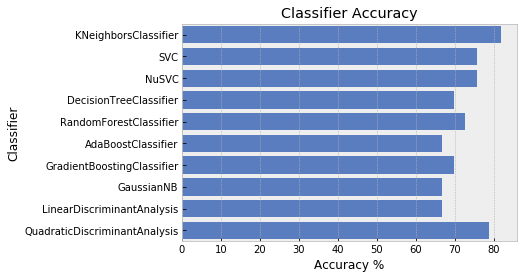

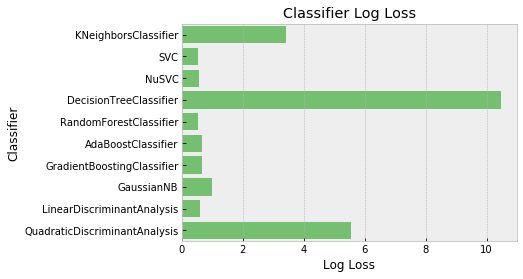

In [33]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

# RANDOM FOREST

In [0]:
from random import seed
seed(12345)

In [0]:
# Parámetros para optimizar el modelo de RF
criterion = ['gini','entropy']
n=[5,10,20,50]
depth=[2,3,5,8,10,30,100]

param_grid = {'criterion': criterion,
              'n_estimators': n,
             'max_depth':depth}


In [0]:
# GridSearch con modelo RF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
grid = GridSearchCV(RandomForestClassifier(),param_grid=param_grid,n_jobs=1,cv=10,verbose=True, scoring = 'recall')

In [37]:
# Entrenar modelo
#y_test_orig= lb.inverse_transform(y_test, threshold=0.5)
grid.fit(X_train,y_train)
pred = grid.predict(X_test)
m_best = grid.best_estimator_
score = grid.score(X_test,y_test)


Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed:    9.3s finished


In [38]:
conf_mat = confusion_matrix(y_test,pred)
print(conf_mat)
print(score)
print(m_best)

[[25  0]
 [ 6  2]]
1.0
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [39]:
from sklearn.metrics import precision_score
y_pred = m_best.predict(X_test)
precision_score(y_test, y_pred)

0.8064516129032258

In [40]:
## Metricas de validación
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.81      1.00      0.89        25
     class 2       1.00      0.25      0.40         8

    accuracy                           0.82        33
   macro avg       0.90      0.62      0.65        33
weighted avg       0.85      0.82      0.77        33



In [41]:
grid.best_estimator_.feature_importances_

array([0.02915, 0.     , 0.03565, 0.16631, 0.24259, 0.06554, 0.     , 0.04169, 0.06751, 0.     , 0.     ,
       0.     , 0.00985, 0.16096, 0.03959, 0.06492, 0.07624])

In [43]:
data_.columns

Index(['Mod_comb', 'rk_peligro', 'LST', 'Velocidad_Viento', 'Humedad_Relativa',
       'Temperatura_Media', 'fechaMonth', 'fechaWeek', 'fechaDay',
       'fechaDayofweek', 'fechaDayofyear', 'cat_dir_viento', 'ned_hidricas',
       'vulnerabilidad', 'riesgos_generales_cuenca', 'riesgos_pendientes',
       'ndvi_norm'],
      dtype='object')

In [0]:
import pandas as pd
feature_importances = pd.DataFrame(grid.best_estimator_.feature_importances_,
                                   index = data_.columns,
                                    columns=['importance']).sort_values('importance',     
                                                                        ascending=False)

In [45]:
feature_importances

,importance
Humedad_Relativa,0.242587
Velocidad_Viento,0.166313
vulnerabilidad,0.160958
ndvi_norm,0.076239
fechaDay,0.067514
Temperatura_Media,0.065541
riesgos_pendientes,0.064916
fechaWeek,0.041693
riesgos_generales_cuenca,0.039593
LST,0.035651


In [46]:
df1.columns[11]

'cat_incendio'

In [0]:
#Se separan las entradas de las salidas, también nos quedamos con las columnas que nos parecen importantes
    outputs = df1.iloc[:,11]
    data_=df1.drop(['cat_incendio'],axis=1)
    inputs = data_[[ 'Velocidad_Viento', 'Humedad_Relativa','vulnerabilidad',
       'Temperatura_Media',
       'ned_hidricas',
       'ndvi_norm']]
    Input_Data = inputs.values[:,:]
    Output_Data = list(outputs.values[:])


In [48]:
df1.columns

Index(['Mod_comb', 'rk_peligro', 'LST', 'Velocidad_Viento', 'Humedad_Relativa',
       'Temperatura_Media', 'fechaMonth', 'fechaWeek', 'fechaDay',
       'fechaDayofweek', 'fechaDayofyear', 'cat_incendio', 'cat_dir_viento',
       'ned_hidricas', 'vulnerabilidad', 'riesgos_generales_cuenca',
       'riesgos_pendientes', 'ndvi_norm'],
      dtype='object')

In [0]:
X_train,X_test,y_train,y_test = train_test_split(Input_Data,Output_Data,test_size=0.3, stratify=df1.cat_incendio)
# Normalizar valores antes de introducir en el modelo
Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

# Modelo base

In [0]:
# basicas
import pandas as pd 
import numpy as np 

# Visualizacción
import matplotlib.pyplot as plt
import seaborn as sns

# para contar valores
from collections import Counter

# modelos 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# para muestras no balanceadas
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

# Métricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Tiempo 
import datetime as dt


def matriz_confusion(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels= ["Inc_peq", "Inc_grand"], yticklabels= ["Inc_peq", "Inc_grand"], annot=True, fmt="d");
    plt.title("Matriz de confusión")
    plt.ylabel('Realidad')
    plt.xlabel('Predicción')
    plt.show()
    
def reg_log(X_train, X_test, y_train, y_test):
    model_reg_log = LogisticRegression(random_state=69, n_jobs=-1)
    model_reg_log.fit(X_train,y_train)
    return model_reg_log

def rf(X_train, X_test, y_train, y_test):
    model_rf = RandomForestClassifier(n_estimators=100,random_state=69,n_jobs=-1)
    model_rf.fit(X_train,y_train)
    return model_rf



In [51]:
rf = GridSearchCV(RandomForestClassifier(),param_grid=param_grid,n_jobs=1,cv=10,verbose=True,scoring='recall')

rf.fit(X_train,y_train)
pred = rf.predict(X_test)
score = rf.score(X_test,y_test)

conf_mat = confusion_matrix(y_test,pred)
print(conf_mat)
print(score)

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[22  3]
 [ 5  3]]
0.88


[Parallel(n_jobs=1)]: Done 560 out of 560 | elapsed:    9.0s finished


In [52]:
## Metricas de validación
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.77      0.96      0.86        25
     class 2       0.50      0.12      0.20         8

    accuracy                           0.76        33
   macro avg       0.64      0.54      0.53        33
weighted avg       0.71      0.76      0.70        33



In [0]:
result = pd.DataFrame(columns = ['Modelo','Observación', 'Accuracy', 'Precisión', 'Recall', 'f1-score'])

# definimos una función para insertar los resultados:
def insert_result(modelo,obs , pred):
  n = result.shape[0]
  # calculamos las diferentes métricas:
  acc = accuracy_score(y_test, pred)
  prec = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  
  result.loc[n] = [modelo, obs, acc, prec, recall, f1]

In [54]:
pred_y = rf.predict(X_test)
insert_result('RF', 'Modelo_base', pred_y)
result

,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154


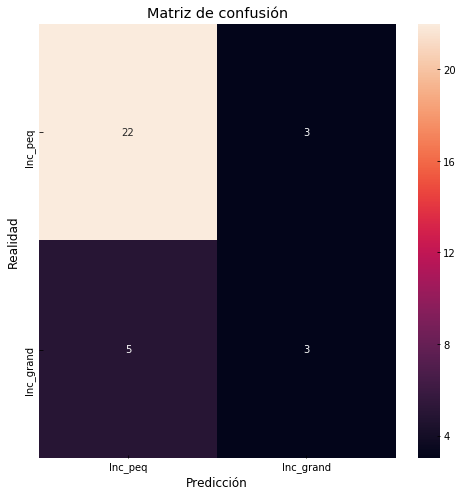

In [55]:
matriz_confusion(y_test,pred_y)

# MLP

In [0]:
# Parámetros para optimizar el modelo de MLP
parameter_grid_MLP = {
            'hidden_layer_sizes': [(10),(30),(50),(100),(10,10),(30,30),(50,50),(100,100)],
            'solver': ['lbfgs','sgd','adam'],
            'activation' : ['identity','logistic','tanh','relu'],
            'learning_rate': ['constant','adaptive'],
            'alpha': [0.0001,0.001,0.005,0.01]
            }



In [57]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

mlp = GridSearchCV(MLPClassifier(early_stopping=True),param_grid=parameter_grid_MLP,cv=5,verbose=True,n_jobs=-2)
mlp.fit(X_train,np.ravel(y_train))
pred= mlp.predict(X_test)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 3840 out of 3840 | elapsed:  2.3min finished


In [58]:
insert_result('MLP', 'Modelo_base', pred)
result

,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429


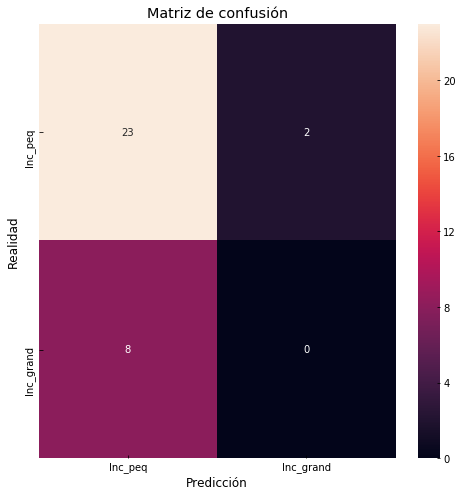

In [59]:
matriz_confusion(y_test,pred)

# GRADIENT BOOSTING

In [60]:
## GRADIENT BOOSTING - modelo base
loss=['deviance','exponential']
criterion = ['friedman_mse']
learning_rate=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
n=[10,50,70,80,100]

param_grid = {'loss': loss,
                  'n_estimators':n,
                  'learning_rate':learning_rate,
                  'criterion':criterion}


gbc = GridSearchCV(GradientBoostingClassifier(),param_grid=param_grid,n_jobs=-2,cv=10,verbose=True)
   
gbc.fit(X_train,np.ravel(y_train))
pred= gbc.predict(X_test)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 900 out of 900 | elapsed:   16.6s finished


In [61]:
insert_result('GB', 'Modelo_base', pred)
result

,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510


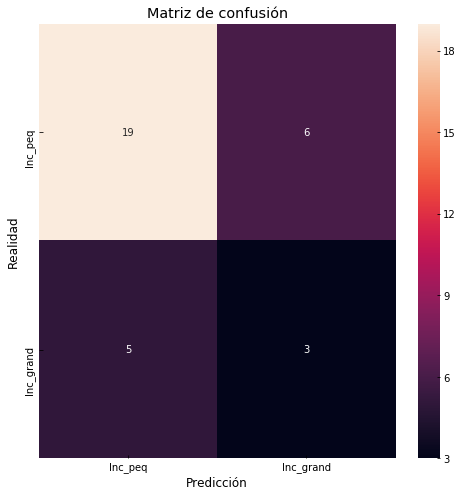

In [62]:
matriz_confusion(y_test,pred)

# XGBOOST

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1215 out of 1215 | elapsed:   14.4s finished


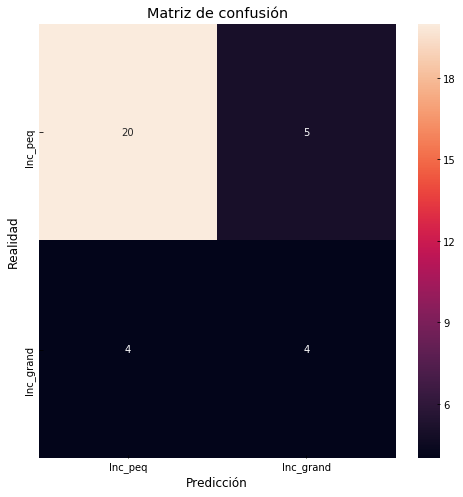

In [63]:
### XBOOST ###
import xgboost as xgb
from scipy.stats import uniform, randint

xgb_model = xgb.XGBClassifier()
    
parameter_grid_XGBOOST = {
            'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
            }
    
    
xgb = GridSearchCV(xgb_model, param_grid=parameter_grid_XGBOOST, cv=3, verbose=1, n_jobs=1, return_train_score=True)
xgb.fit(X_train,np.ravel(y_train))
pred = xgb.predict(X_test)

insert_result('XBOOST', 'Modelo_base', pred)
result

matriz_confusion(y_test,pred)

In [64]:
result

,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327


# BAGGING

In [65]:
### BAGGING ### 

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


n=[10,50,70,80,100]
base= [DecisionTreeClassifier(),KNeighborsClassifier()]
param_grid = {'n_estimators': n,
                  'base_estimator':base}

grid = GridSearchCV(BaggingClassifier(),param_grid=param_grid,n_jobs=-2,cv=10,verbose=True)
    
grid.fit(X_train,np.ravel(y_train))
pred = grid.predict(X_test)

insert_result('BAGGING', 'Modelo_base', pred)
result

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:    5.4s finished


,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000


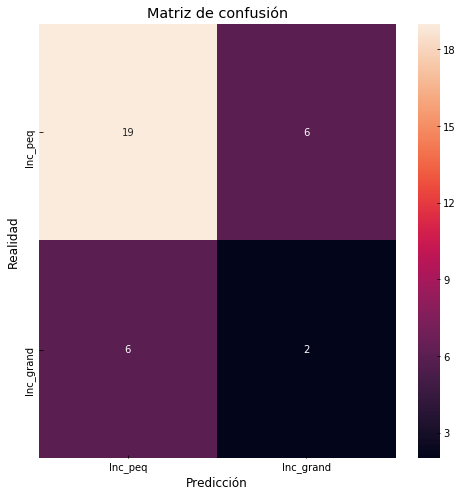

In [66]:
matriz_confusion(y_test,pred)

# ADABOOSTCLASSIFIER

In [67]:
### ADABOOSTCLASSIFIER ###

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ada_model=AdaBoostClassifier(base_estimator=dtc, n_estimators=100)
ada_model=ada_model.fit(X_train,y_train)
print(ada_model)
AdaBoostClassifier(algorithm='SAMME.R',
    base_estimator=DecisionTreeClassifier(class_weight=None, 
    criterion='entropy',max_depth=3,
    max_features=None, max_leaf_nodes=None,
    min_impurity_decrease=0.0, min_impurity_split=None,
    min_samples_leaf=1, min_samples_split=2,
    min_weight_fraction_leaf=0.0, presort=False, random_state=None,
    splitter='best'),
    learning_rate=1.0, n_estimators=100, random_state=None)

ytest_pred=ada_model.predict(X_test)

insert_result('ADABOOSTCLASSIFIER', 'Modelo_base', ytest_pred)
result

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                          

,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000
5,ADABOOSTCLASSIFIER,Modelo_base,0.696970,0.800000,0.80,0.800000


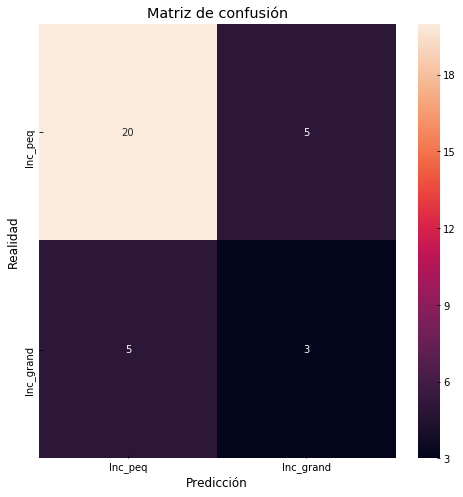

In [68]:
matriz_confusion(y_test,ytest_pred)

# SVC

In [69]:
### SVC ###
from sklearn.svm import SVC

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

svc1 = GridSearchCV(SVC(), param_grid=tuned_parameters, cv=3, verbose=1, n_jobs=1, return_train_score=True)
svc1.fit(X_train,y_train)
pred_y = svc1.predict(X_test)

insert_result('SVC', 'Modelo_base', pred_y)
result

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.2s finished


,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000
5,ADABOOSTCLASSIFIER,Modelo_base,0.696970,0.800000,0.80,0.800000
6,SVC,Modelo_base,0.757576,0.757576,1.00,0.862069


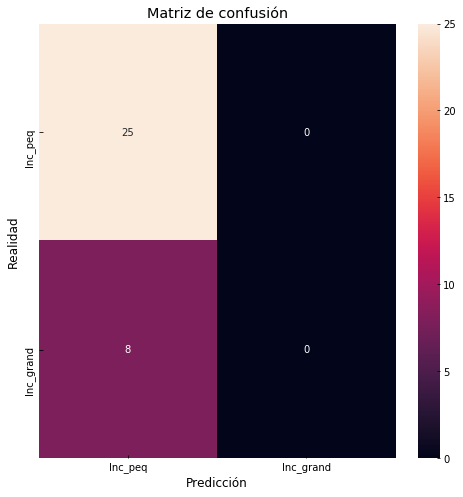

In [70]:
matriz_confusion(y_test,pred_y)

# LOGISTICO

In [71]:
### LOGISTICO ###

from sklearn.linear_model import LogisticRegression
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)



logistic_mod = GridSearchCV(LogisticRegression(),param_grid = hyperparameters, 
                               cv = 2,  n_jobs=-1)

model_res = logistic_mod.fit(X_train, y_train)

ytest_pred=model_res.predict(X_test)

insert_result('Logistic', 'Modelo_base', ytest_pred)
result

,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000
5,ADABOOSTCLASSIFIER,Modelo_base,0.696970,0.800000,0.80,0.800000
6,SVC,Modelo_base,0.757576,0.757576,1.00,0.862069
7,Logistic,Modelo_base,0.818182,0.851852,0.92,0.884615


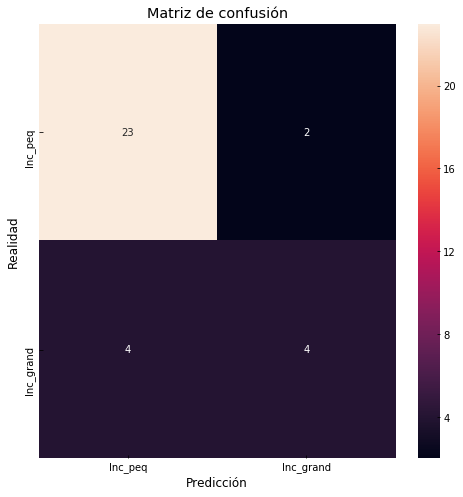

In [72]:
matriz_confusion(y_test,ytest_pred)

# Upsample

In [0]:
os = RandomOverSampler(random_state=69)
X_train_over, y_train_over = os.fit_sample(X_train, y_train)

In [77]:
print(collections.Counter(y_train))

Counter({1: 57, 2: 20})


In [78]:
print(collections.Counter(y_train_over))

Counter({2: 57, 1: 57})


In [0]:
### RF - UPSAMPLE ###
def rf(X_train, X_test, y_train, y_test):
    model_rf = RandomForestClassifier(n_estimators=100,random_state=69,n_jobs=-1)
    model_rf.fit(X_train,y_train)
    return model_rf

In [80]:
rf_over = rf(X_train_over, X_test, y_train_over, y_test)
pred_y = rf_over.predict(X_test)
insert_result('RF', 'Upsample', pred_y)
result

,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000
5,ADABOOSTCLASSIFIER,Modelo_base,0.696970,0.800000,0.80,0.800000
6,SVC,Modelo_base,0.757576,0.757576,1.00,0.862069
7,Logistic,Modelo_base,0.818182,0.851852,0.92,0.884615
8,RF,Upsample,0.757576,0.840000,0.84,0.840000


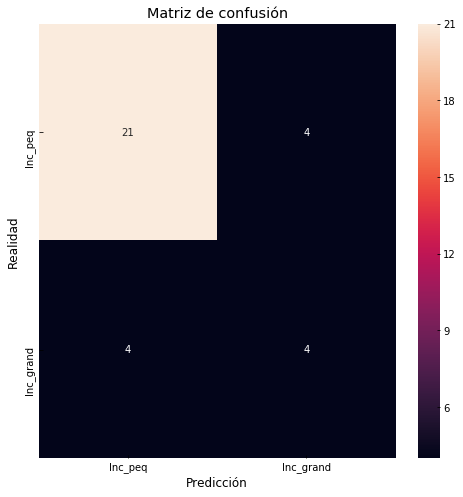

In [81]:
matriz_confusion(y_test,pred_y)

In [82]:
### MLP - UPSAMPLE ###
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

mlp = GridSearchCV(MLPClassifier(early_stopping=True),param_grid=parameter_grid_MLP,cv=5,verbose=True,n_jobs=-2)
mlp.fit(X_train_over,np.ravel(y_train_over))
pred= mlp.predict(X_test)

insert_result('MLP', 'Upsample', pred)
result

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 3840 out of 3840 | elapsed:  2.5min finished


,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000
5,ADABOOSTCLASSIFIER,Modelo_base,0.696970,0.800000,0.80,0.800000
6,SVC,Modelo_base,0.757576,0.757576,1.00,0.862069
7,Logistic,Modelo_base,0.818182,0.851852,0.92,0.884615
8,RF,Upsample,0.757576,0.840000,0.84,0.840000
9,MLP,Upsample,0.696970,0.826087,0.76,0.791667


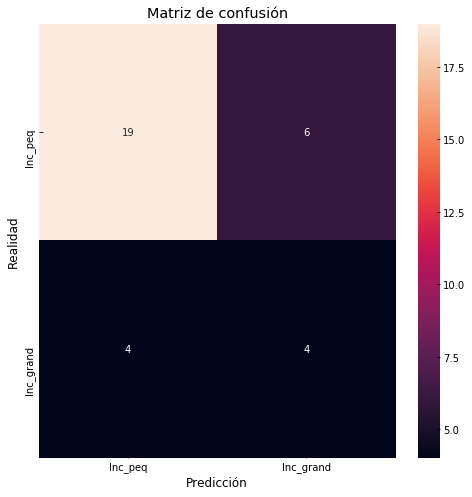

In [83]:
matriz_confusion(y_test,pred)

In [84]:
### LOGISTICO - UPSAMPLE ###

from sklearn.linear_model import LogisticRegression
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)



logistic_mod = GridSearchCV(LogisticRegression(),param_grid = hyperparameters, 
                               cv = 2,  n_jobs=-1)

model_res = logistic_mod.fit(X_train_over, y_train_over)

ytest_pred=model_res.predict(X_test)

insert_result('Logistic', 'Upsample', ytest_pred)
result

,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000
5,ADABOOSTCLASSIFIER,Modelo_base,0.696970,0.800000,0.80,0.800000
6,SVC,Modelo_base,0.757576,0.757576,1.00,0.862069
7,Logistic,Modelo_base,0.818182,0.851852,0.92,0.884615
8,RF,Upsample,0.757576,0.840000,0.84,0.840000
9,MLP,Upsample,0.696970,0.826087,0.76,0.791667


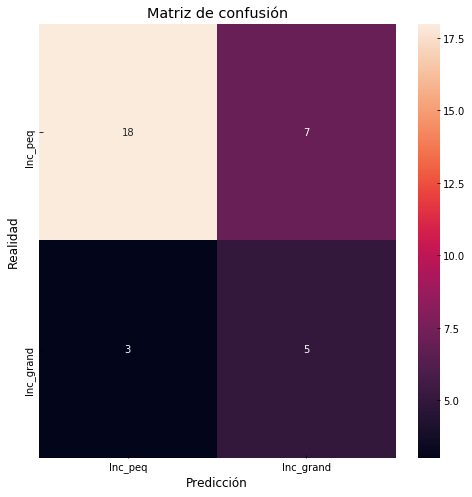

In [85]:
matriz_confusion(y_test,ytest_pred)

In [86]:
### SVC ###
from sklearn.svm import SVC

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

svc1 = GridSearchCV(SVC(), param_grid=tuned_parameters, cv=3, verbose=1, n_jobs=1, return_train_score=True)
svc1.fit(X_train_over,y_train_over)
pred_y = svc1.predict(X_test)

insert_result('SVC', 'Upsample', pred_y)
result

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.3s finished


,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000
5,ADABOOSTCLASSIFIER,Modelo_base,0.696970,0.800000,0.80,0.800000
6,SVC,Modelo_base,0.757576,0.757576,1.00,0.862069
7,Logistic,Modelo_base,0.818182,0.851852,0.92,0.884615
8,RF,Upsample,0.757576,0.840000,0.84,0.840000
9,MLP,Upsample,0.696970,0.826087,0.76,0.791667


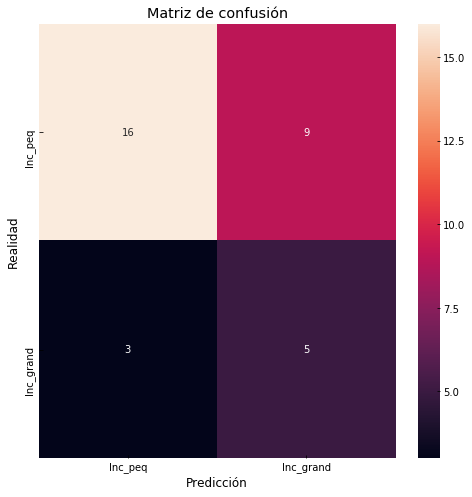

In [87]:
matriz_confusion(y_test,pred_y)

# SMOTE

In [0]:
smote = SMOTETomek(random_state=69)
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

In [89]:
print(collections.Counter(y_train_smote))

Counter({2: 56, 1: 56})


In [90]:
### RF -SMOTE ###
rf_smote = rf(X_train_smote, X_test, y_train_smote, y_test)
pred_y = rf_smote.predict(X_test)
insert_result('RF', 'Smote', pred_y)
result

,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000
5,ADABOOSTCLASSIFIER,Modelo_base,0.696970,0.800000,0.80,0.800000
6,SVC,Modelo_base,0.757576,0.757576,1.00,0.862069
7,Logistic,Modelo_base,0.818182,0.851852,0.92,0.884615
8,RF,Upsample,0.757576,0.840000,0.84,0.840000
9,MLP,Upsample,0.696970,0.826087,0.76,0.791667


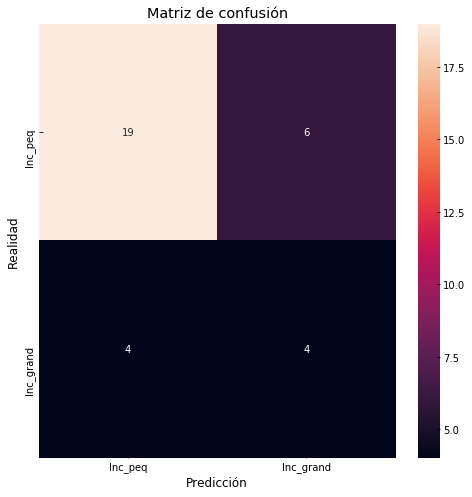

In [91]:
matriz_confusion(y_test,pred_y)

In [92]:
### MLP - SMOTE ###
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

mlp = GridSearchCV(MLPClassifier(early_stopping=True),param_grid=parameter_grid_MLP,cv=5,verbose=True,n_jobs=-2)
mlp.fit(X_train_smote,np.ravel(y_train_smote))
pred= mlp.predict(X_test)

insert_result('MLP', 'Smote', pred)
result

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done 3840 out of 3840 | elapsed:  2.5min finished


,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000
5,ADABOOSTCLASSIFIER,Modelo_base,0.696970,0.800000,0.80,0.800000
6,SVC,Modelo_base,0.757576,0.757576,1.00,0.862069
7,Logistic,Modelo_base,0.818182,0.851852,0.92,0.884615
8,RF,Upsample,0.757576,0.840000,0.84,0.840000
9,MLP,Upsample,0.696970,0.826087,0.76,0.791667


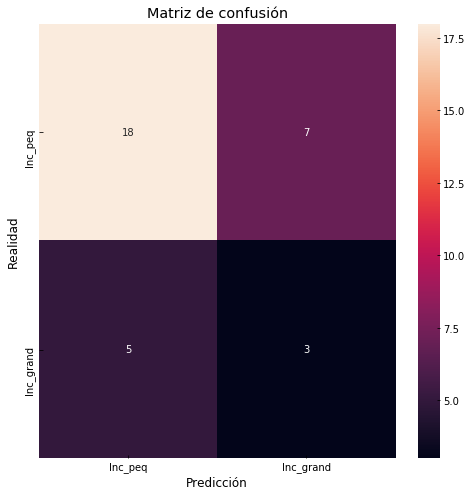

In [93]:
matriz_confusion(y_test,pred)

In [94]:
### LOGISTICO - SMOTE ###

from sklearn.linear_model import LogisticRegression
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)



logistic_mod = GridSearchCV(LogisticRegression(),param_grid = hyperparameters, 
                               cv = 2,  n_jobs=-1)

model_res = logistic_mod.fit(X_train_smote, y_train_smote)

ytest_pred=model_res.predict(X_test)

insert_result('Logistic', 'Smote', ytest_pred)
result

,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000
5,ADABOOSTCLASSIFIER,Modelo_base,0.696970,0.800000,0.80,0.800000
6,SVC,Modelo_base,0.757576,0.757576,1.00,0.862069
7,Logistic,Modelo_base,0.818182,0.851852,0.92,0.884615
8,RF,Upsample,0.757576,0.840000,0.84,0.840000
9,MLP,Upsample,0.696970,0.826087,0.76,0.791667


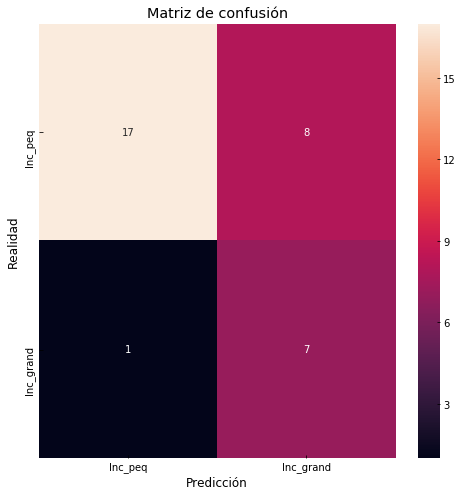

In [95]:
matriz_confusion(y_test,ytest_pred)

In [114]:
### SVC - SMOTE ###
from sklearn.svm import SVC

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

svc1 = GridSearchCV(SVC(), param_grid=tuned_parameters, cv=3, verbose=1, n_jobs=1, return_train_score=True)
svc1.fit(X_train_smote,y_train_smote)
pred_y = svc1.predict(X_test)

insert_result('SVC', 'Smote', pred_y)
result

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.2s finished


,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000
5,ADABOOSTCLASSIFIER,Modelo_base,0.696970,0.800000,0.80,0.800000
6,SVC,Modelo_base,0.757576,0.757576,1.00,0.862069
7,Logistic,Modelo_base,0.818182,0.851852,0.92,0.884615
8,RF,Upsample,0.757576,0.840000,0.84,0.840000
9,MLP,Upsample,0.696970,0.826087,0.76,0.791667


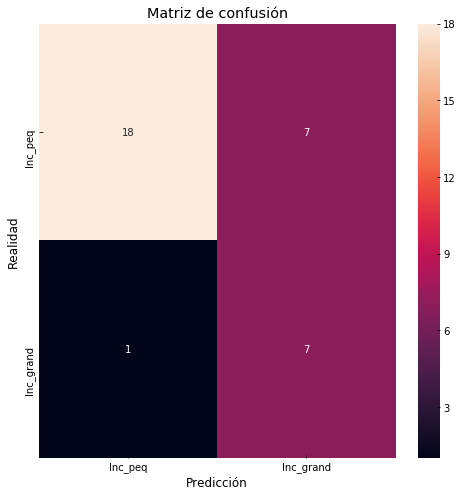

In [115]:
matriz_confusion(y_test,pred_y)

In [119]:
np.ravel(y_test)

array([1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2])

In [117]:
y_pred

array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1])

In [121]:
Scaler.inverse_transform(X_test)

array([[  1.8    ,  75.     ,   2.2    ,  27.2    , 594.     ,   0.44208],
       [  1.6    ,  95.2    ,   2.6    ,  20.4    , 542.1    ,   0.84541],
       [  1.1    ,  90.     ,   2.4    ,  27.2    , 535.8    ,   0.65152],
       [  1.4    ,  32.1    ,   2.4    ,  28.1    , 982.37   ,   0.02215],
       [  7.     ,  38.     ,   2.     ,  25.     , 160.03   ,  -0.12825],
       [ 15.     ,  44.     ,   1.8    ,  27.     , 318.14   ,  -0.084  ],
       [  1.8    , 100.     ,   2.6    ,  22.1    , 398.     ,   0.5    ],
       [ 10.     ,  41.3    ,   2.2    ,  20.3    , 439.33   ,   0.2355 ],
       [ 17.     ,  27.9    ,   1.4    ,  33.     , 335.34   ,   1.08934],
       [  0.8    ,  98.6    ,   2.6    ,  22.6    , 658.     ,   0.40854],
       [  1.5    ,  46.8    ,   2.     ,  20.8    , 168.39   ,   0.5    ],
       [  1.6    ,  27.7    ,   2.     ,  28.     , 474.57   ,   0.13328],
       [  1.5    ,  68.1    ,   2.6    ,  30.1    ,  33.35   ,   0.6685 ],
       [  1.5    ,  34.7 

In [129]:
df3=df1[ 'Velocidad_Viento']==7
df4=df1[df3]
df4.head()

,Mod_comb,rk_peligro,LST,Velocidad_Viento,Humedad_Relativa,Temperatura_Media,fechaMonth,fechaWeek,fechaDay,fechaDayofweek,fechaDayofyear,cat_incendio,cat_dir_viento,ned_hidricas,vulnerabilidad,riesgos_generales_cuenca,riesgos_pendientes,ndvi_norm
76,3.0,2,0.000000,7.0,38.0,25.0,6,26,29,4,180,2,3,160.03,2.0,4.666667,2.0,-0.128252
96,5.0,4,42.165578,7.0,20.0,32.0,7,31,27,1,209,2,5,354.67,2.4,4.666667,3.0,0.013534


# Estrategia --> Ensamble de modelos con balanceo.

In [98]:
## BALANCED BAGGING NORMAL
bbc = BalancedBaggingClassifier(base_estimator = DecisionTreeClassifier(),
                               sampling_strategy='auto',
                               random_state=0)

bbc.fit(X_train, y_train)
pred_y = bbc.predict(X_test)
insert_result('Bagging', 'Ensamble', pred_y)
result

,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000
5,ADABOOSTCLASSIFIER,Modelo_base,0.696970,0.800000,0.80,0.800000
6,SVC,Modelo_base,0.757576,0.757576,1.00,0.862069
7,Logistic,Modelo_base,0.818182,0.851852,0.92,0.884615
8,RF,Upsample,0.757576,0.840000,0.84,0.840000
9,MLP,Upsample,0.696970,0.826087,0.76,0.791667


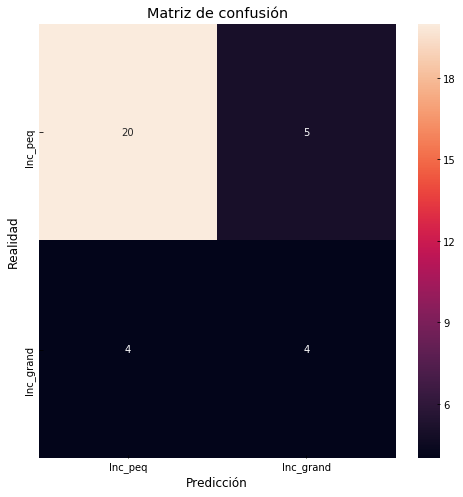

In [99]:
matriz_confusion(y_test,pred_y)

In [100]:
## BALANCED BAGGING CON DATOS UPSAMPLE
bbc = BalancedBaggingClassifier(base_estimator = DecisionTreeClassifier(),
                               sampling_strategy='auto',
                               random_state=0)

bbc.fit(X_train_over, y_train_over)
pred_y = bbc.predict(X_test)
insert_result('Bagging', 'Ensamble_UPSAMPLE', pred_y)
result

,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000
5,ADABOOSTCLASSIFIER,Modelo_base,0.696970,0.800000,0.80,0.800000
6,SVC,Modelo_base,0.757576,0.757576,1.00,0.862069
7,Logistic,Modelo_base,0.818182,0.851852,0.92,0.884615
8,RF,Upsample,0.757576,0.840000,0.84,0.840000
9,MLP,Upsample,0.696970,0.826087,0.76,0.791667


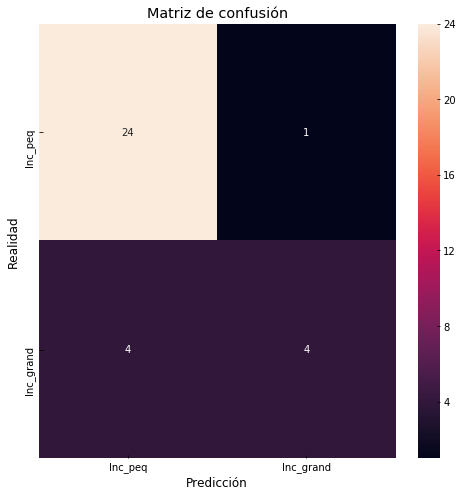

In [101]:
matriz_confusion(y_test,pred_y)

In [102]:
## BALANCED BAGGING CON DATOS SMOTE
bbc = BalancedBaggingClassifier(base_estimator = DecisionTreeClassifier(),
                               sampling_strategy='auto',
                               random_state=0)

bbc.fit(X_train_smote, y_train_smote)
pred_y = bbc.predict(X_test)
insert_result('Bagging', 'Ensamble_SMOTE', pred_y)
result

,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000
5,ADABOOSTCLASSIFIER,Modelo_base,0.696970,0.800000,0.80,0.800000
6,SVC,Modelo_base,0.757576,0.757576,1.00,0.862069
7,Logistic,Modelo_base,0.818182,0.851852,0.92,0.884615
8,RF,Upsample,0.757576,0.840000,0.84,0.840000
9,MLP,Upsample,0.696970,0.826087,0.76,0.791667


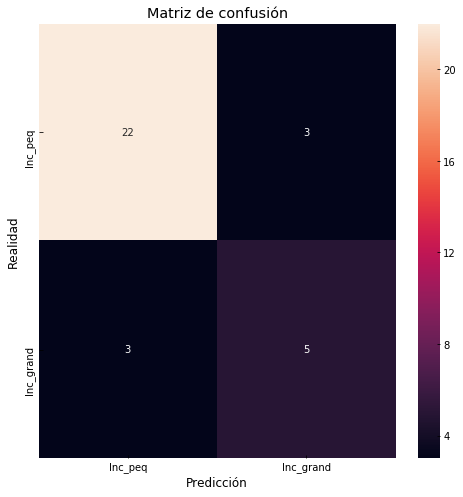

In [103]:
matriz_confusion(y_test,pred_y)

In [104]:
## BALANCED BAGGING CON DATOS SMOTE OPTIMIZADO
sampling=['auto','majority','not minority']
n=[10,50,70,80,100]
base= [DecisionTreeClassifier()]


param_grid = {'sampling_strategy': sampling,
                  'n_estimators':n,
                  'base_estimator':base}



bbc1= GridSearchCV(BalancedBaggingClassifier(),param_grid=param_grid, n_jobs=-1)


bbc1.fit(X_train_smote, y_train_smote)
pred_y = bbc1.predict(X_test)
insert_result('Bagging', 'Ensamble_SMOTE_OPTIM', pred_y)
result

,Modelo,Observación,Accuracy,Precisión,Recall,f1-score
0,RF,Modelo_base,0.757576,0.814815,0.88,0.846154
1,MLP,Modelo_base,0.696970,0.741935,0.92,0.821429
2,GB,Modelo_base,0.666667,0.791667,0.76,0.775510
3,XBOOST,Modelo_base,0.727273,0.833333,0.80,0.816327
4,BAGGING,Modelo_base,0.636364,0.760000,0.76,0.760000
5,ADABOOSTCLASSIFIER,Modelo_base,0.696970,0.800000,0.80,0.800000
6,SVC,Modelo_base,0.757576,0.757576,1.00,0.862069
7,Logistic,Modelo_base,0.818182,0.851852,0.92,0.884615
8,RF,Upsample,0.757576,0.840000,0.84,0.840000
9,MLP,Upsample,0.696970,0.826087,0.76,0.791667


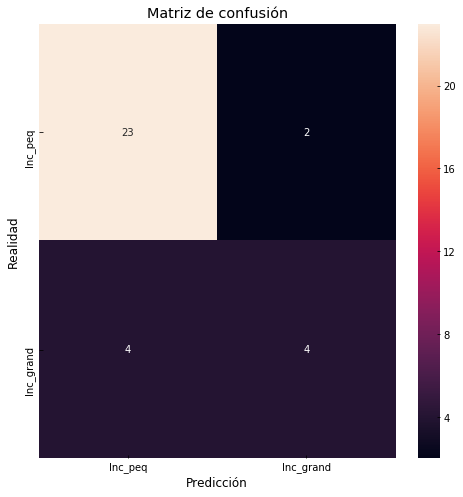

In [105]:
matriz_confusion(y_test,pred_y)

#Estrategia --> Puntos de corte.

In [0]:
# Usaremos el modelo de Random Forests que utilizamos como base
df2 = pd.DataFrame({'0':bbc1.predict_proba(X_test)[:,0],
                   '1':bbc1.predict_proba(X_test)[:,1],
                  'pred':bbc1.predict(X_test),
                  'y_test':y_test})

In [0]:
df2['alternativo']= df2['1'].apply(lambda x: 0 if x<0.30 else 1)

In [108]:
# Observando el recall
print('Recall con la predicción normal: ', recall_score(df2.y_test, df2.pred))
print('Recall con la predicción alternativa: ', recall_score(df2.y_test, df2.alternativo, 
                                           pos_label='positive',
                                           average='weighted'))

Recall con la predicción normal:  0.92
Recall con la predicción alternativa:  0.3333333333333333


In [109]:
# optimizar una este parametro 
cortes =[]
scores = []

for corte in np.arange(0, 1, 0.1):
  alternativo = df2['1'].apply(lambda x: 0 if x<corte else 1)
  score = recall_score(df2.y_test, alternativo, 
                                           pos_label='positive',
                                           average='weighted')
  
  cortes.append(corte)
  scores.append(score)
  
puntos_de_cortes = pd.DataFrame({'Cortes':cortes,
                                'Score':scores})

puntos_de_cortes.sort_values(by='Score',inplace=True,ascending=False)
puntos_de_cortes

,Cortes,Score
0,0.0,0.757576
1,0.1,0.666667
2,0.2,0.545455
3,0.3,0.181818
4,0.4,0.181818
5,0.5,0.090909
6,0.6,0.030303
7,0.7,0.030303
8,0.8,0.030303
9,0.9,0.000000


In [0]:
df2['alternativo']= df2['1'].apply(lambda x: 0 if x<0.10 else 1)

In [111]:
# Observando el recall
print('Recall con la predicción normal: ', recall_score(df2.y_test, df2.pred, 
                                           pos_label='positive',
                                           average='weighted'))
print('Recall con la predicción alternativa: ', recall_score(df2.y_test, df2.alternativo, 
                                           pos_label='positive',
                                           average='weighted'))

Recall con la predicción normal:  0.8181818181818182
Recall con la predicción alternativa:  0.6666666666666666


Modelo base: 


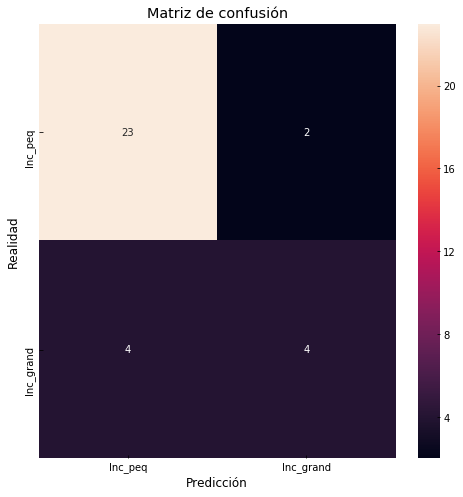

In [112]:
# Veamos la matriz de confusión:
print('Modelo base: ')
matriz_confusion(df2.y_test, df2.pred)

Modelo base con punto de corte alternativo: 


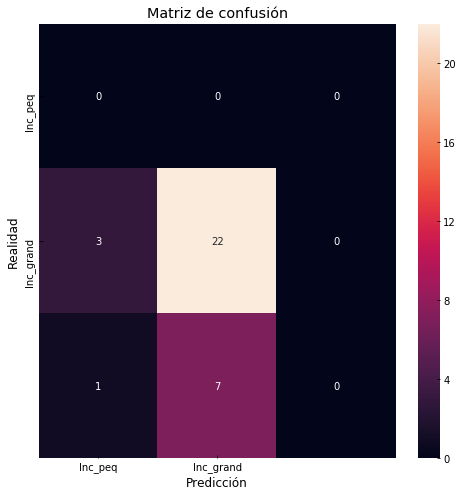

In [113]:
# Veamos la matriz de confusión:
print('Modelo base con punto de corte alternativo: ')
matriz_confusion(df2.y_test, df2.alternativo)

In [0]:
# Veamos la matriz de confusión en el modelo donde hemos obtenido mayor recall
matriz_confusion(y_test,reg_log_balanced.predict(X_test))

#Reducimos el balanceo

In [0]:
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score

def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    print('')

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print('Decision tree classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, pred),
              geometric_mean_score(y_test, pred)))
cm_tree = confusion_matrix(y_test, pred)
fig, ax = plt.subplots()
plot_confusion_matrix(cm_tree, classes=np.unique(outputs), ax=ax,
                      title='Decision tree')



In [0]:
## Classification using bagging classifier with and without sampling
from imblearn.ensemble import BalancedBaggingClassifier


bagging = BaggingClassifier(n_estimators=50, random_state=0, n_jobs=-1)
balanced_bagging = BalancedBaggingClassifier(n_estimators=50, random_state=0,
                                             n_jobs=-1)

bagging.fit(X_train, y_train)
balanced_bagging.fit(X_train, y_train)

y_pred_bc = bagging.predict(X_test)
y_pred_bbc = balanced_bagging.predict(X_test)

In [0]:
print('Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_bc),
              geometric_mean_score(y_test, y_pred_bc)))
cm_bagging = confusion_matrix(y_test, y_pred_bc)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_bagging, classes=np.unique(outputs), ax=ax[0],
                      title='Bagging')

print('Balanced Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_bbc),
              geometric_mean_score(y_test, y_pred_bbc)))
cm_balanced_bagging = confusion_matrix(y_test, y_pred_bbc)
plot_confusion_matrix(cm_balanced_bagging, classes=np.unique(outputs),
                      ax=ax[1], title='Balanced bagging')

In [0]:
## Classification using random forest classifier with and without sampling
from imblearn.ensemble import BalancedRandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=-1)
brf = BalancedRandomForestClassifier(n_estimators=50, random_state=0,
                                     n_jobs=-1)

rf.fit(X_train, y_train)
brf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_brf = brf.predict(X_test)

# Similarly to the previous experiment, the balanced classifier outperform the
# classifier which learn from imbalanced bootstrap samples. In addition, random
# forest outsperforms the bagging classifier.

print('Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_rf),
              geometric_mean_score(y_test, y_pred_rf)))
cm_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(ncols=2)
plot_confusion_matrix(cm_rf, classes=np.unique(outputs), ax=ax[0],
                      title='Random forest')

print('Balanced Random Forest classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
      .format(balanced_accuracy_score(y_test, y_pred_brf),
              geometric_mean_score(y_test, y_pred_brf)))
cm_brf = confusion_matrix(y_test, y_pred_brf)
plot_confusion_matrix(cm_brf, classes=np.unique(outputs), ax=ax[1],
                      title='Balanced random forest')

# AÑADIR NUEVAS MUESTRAS ARTIFICIALES